In [72]:
import pandas as pd

df = pd.read_csv('rows.csv')

/tmp/ipykernel_30809/3153485873.py:3: DtypeWarning: Columns (6,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('rows.csv')


In [140]:
columns_to_drop = [
    'Store Name', 
    'Address',
    'Store Location', 
    'Zip Code', 
    'County Number', 
    'County',
    'Volume Sold (Gallons)',
    'Item Description'
]

df_cleaned = df.drop(columns=columns_to_drop)

# Keep only data from 2020-2023
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned = df_cleaned[df_cleaned['Date'].dt.year.between(2012, 2023)]
#data points:
# 2020    2614365
# 2021    2622712
# 2022    2564565
# 2023    2639557

# Convert negative bottle sales to positive
df_cleaned['Bottles Sold'] = df_cleaned['Bottles Sold'].abs()
# Convert dates to start of week and create a WeekStart column
df_cleaned['WeekStart'] = df_cleaned['Date'] - pd.to_timedelta(df_cleaned['Date'].dt.dayofweek, unit='D')

# Group by Item Number, Store Number and WeekStart to get weekly sums
df_ts = df_cleaned.groupby(['Item Number', 'Store Number', 'WeekStart'])['Bottles Sold'].sum().reset_index()

# Pivot the data to create columns for each week
df_ts = df_ts.pivot(index=['Item Number', 'Store Number'], 
                    columns='WeekStart', 
                    values='Bottles Sold').reset_index()

# Fill any missing values with 0 since no bottles were sold in those weeks
df_ts = df_ts.fillna(0)

# Sort by Item Number and Store Number
df_ts = df_ts.sort_values(['Item Number', 'Store Number'])

In [142]:
# Calculate number of weeks with zero sales for each item-store combination
num_weeks = len(df_ts.columns) - 2  # Subtract 2 for 'Item Number' and 'Store Number' columns
zero_sales_count = (df_ts.iloc[:, 2:] == 0).sum(axis=1)  # Count zeros starting from 3rd column

# Calculate percentage of weeks with zero sales
zero_sales_pct = zero_sales_count / num_weeks

# Keep only rows where less than 10% of weeks have zero sales
df_ts_filtered = df_ts[zero_sales_pct <= 0.1]

In [143]:
df_ts_filtered

WeekStart,Item Number,Store Number,2012-01-02 00:00:00,2012-01-09 00:00:00,2012-01-16 00:00:00,2012-01-23 00:00:00,2012-01-30 00:00:00,2012-02-06 00:00:00,2012-02-13 00:00:00,2012-02-20 00:00:00,...,2023-10-23 00:00:00,2023-10-30 00:00:00,2023-11-06 00:00:00,2023-11-13 00:00:00,2023-11-20 00:00:00,2023-11-27 00:00:00,2023-12-04 00:00:00,2023-12-11 00:00:00,2023-12-18 00:00:00,2023-12-25 00:00:00
93443,10627,2633,48.0,72.0,48.0,60.0,84.0,72.0,72.0,84.0,...,24.0,48.0,24.0,48.0,24.0,24.0,48.0,24.0,48.0,12.0
133093,11297,2106,36.0,36.0,24.0,24.0,36.0,36.0,36.0,36.0,...,12.0,24.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
133371,11297,3773,24.0,12.0,48.0,48.0,48.0,72.0,48.0,84.0,...,108.0,108.0,96.0,36.0,96.0,60.0,84.0,84.0,72.0,96.0
151578,11777,2106,36.0,48.0,36.0,48.0,48.0,60.0,60.0,48.0,...,0.0,0.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.0
151696,11777,2633,132.0,144.0,144.0,132.0,156.0,156.0,156.0,156.0,...,96.0,72.0,132.0,96.0,60.0,120.0,168.0,180.0,72.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541476,87937,2633,24.0,36.0,48.0,24.0,48.0,36.0,48.0,60.0,...,60.0,120.0,84.0,204.0,48.0,36.0,48.0,144.0,36.0,48.0
1553145,88296,4829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,240.0,180.0,240.0,204.0,180.0,216.0,144.0,180.0,264.0,180.0
1585545,89197,3773,12.0,24.0,12.0,12.0,24.0,24.0,12.0,36.0,...,24.0,24.0,24.0,12.0,24.0,0.0,72.0,24.0,24.0,60.0
1598243,89387,3773,0.0,36.0,24.0,0.0,0.0,60.0,12.0,24.0,...,24.0,24.0,0.0,48.0,24.0,12.0,24.0,12.0,24.0,24.0


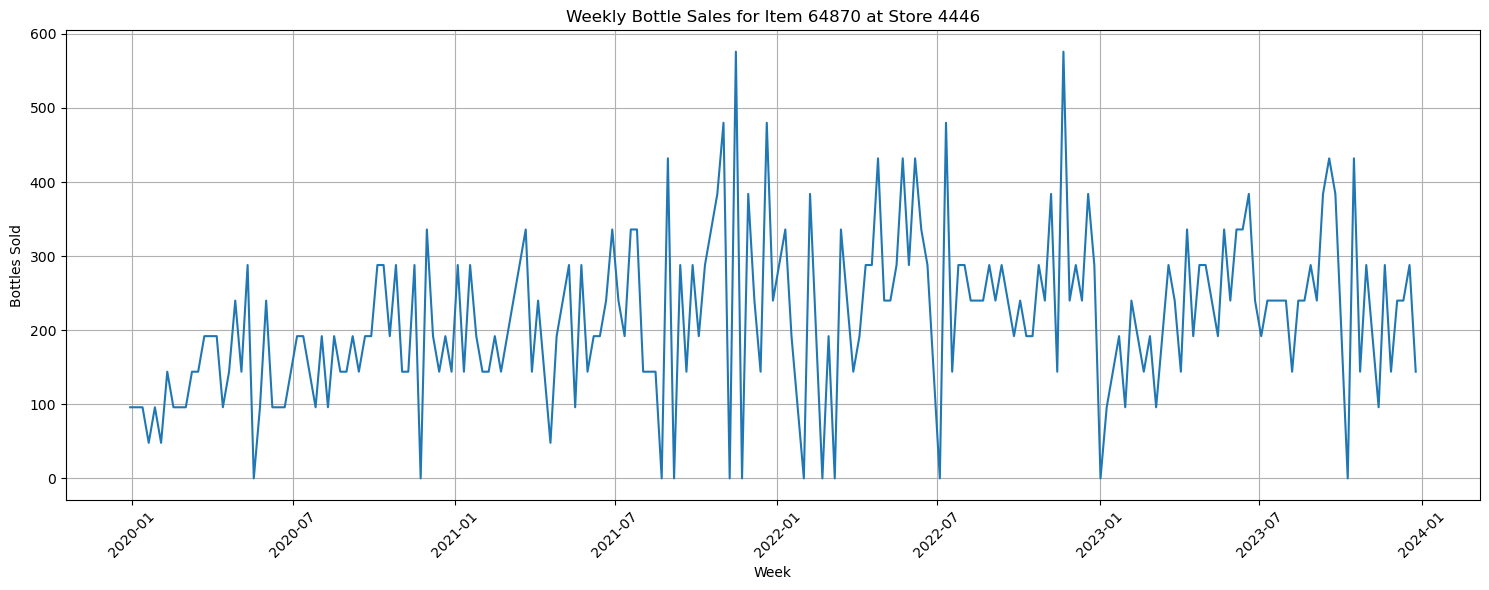

Showing sales data for Item 64870 at Store 4446


In [139]:
# Randomly select one item-store combination
random_row = df_ts_filtered.sample(n=1)
item_num = random_row['Item Number'].iloc[0]
store_num = random_row['Store Number'].iloc[0]

# Get the data for this item-store combination
selected_data = df_ts_filtered[
    (df_ts_filtered['Item Number'] == item_num) & 
    (df_ts_filtered['Store Number'] == store_num)
]

# Create a time series from the data
time_series = selected_data.iloc[0, 2:].reset_index()  # Skip Item/Store columns
time_series.columns = ['Week', 'Bottles']
time_series['Week'] = pd.to_datetime(time_series['Week'])

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(time_series['Week'], time_series['Bottles'])
plt.title(f'Weekly Bottle Sales for Item {item_num} at Store {store_num}')
plt.xlabel('Week')
plt.ylabel('Bottles Sold')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Showing sales data for Item {item_num} at Store {store_num}")


In [127]:
# Count how many stores have the same item number
store_counts = df_ts_filtered.groupby('Item Number')['Store Number'].count()

# Count how many items have each number of stores
items_per_store_count = store_counts.value_counts().sort_index()
print("Number of items with X stores:")
print("(X stores : number of items)")
print(items_per_store_count)

print("\nDetailed breakdown:")
for num_stores, num_items in items_per_store_count.items():
    print(f"{num_items} items are sold in exactly {num_stores} stores")

Number of items with X stores:
(X stores : number of items)
Store Number
1     49
2     23
3      9
4      6
5      6
6      6
7      3
8      2
9      1
11     2
12     1
13     1
14     1
28     1
Name: count, dtype: int64

Detailed breakdown:
49 items are sold in exactly 1 stores
23 items are sold in exactly 2 stores
9 items are sold in exactly 3 stores
6 items are sold in exactly 4 stores
6 items are sold in exactly 5 stores
6 items are sold in exactly 6 stores
3 items are sold in exactly 7 stores
2 items are sold in exactly 8 stores
1 items are sold in exactly 9 stores
2 items are sold in exactly 11 stores
1 items are sold in exactly 12 stores
1 items are sold in exactly 13 stores
1 items are sold in exactly 14 stores
1 items are sold in exactly 28 stores


In [121]:
df_ts_filtered.to_csv('weekly_sales_2020_2023.csv', index=False)
